# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
import matplotlib.pyplot as plt
import os
import random
import cv2
import numpy as np


path = r"C:\Users\gamin\.cache\kagglehub\datasets\ruizgara\socofing\versions\2\SOCOFing"
print("Path to dataset files:", path)

Path to dataset files: C:\Users\gamin\.cache\kagglehub\datasets\ruizgara\socofing\versions\2\SOCOFing


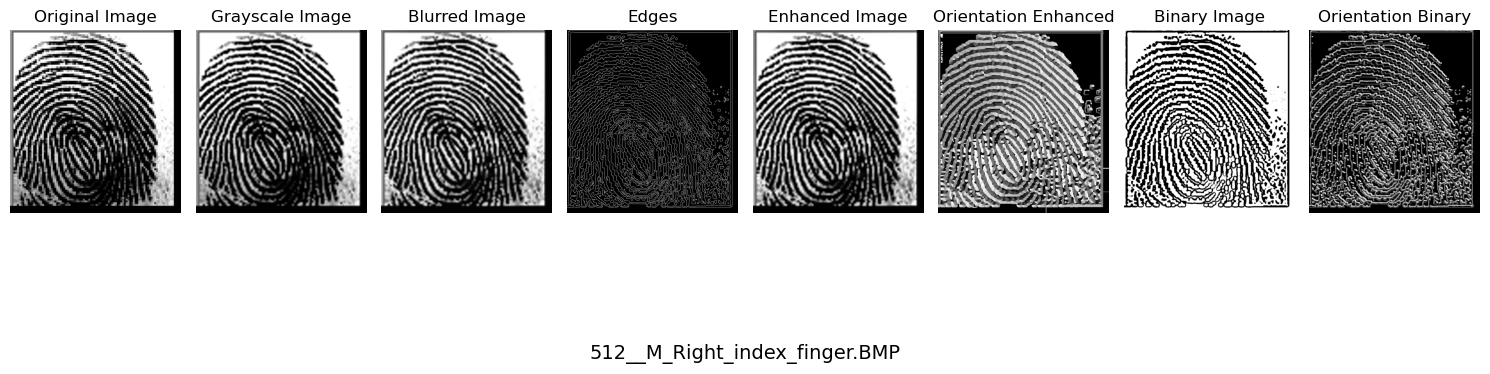

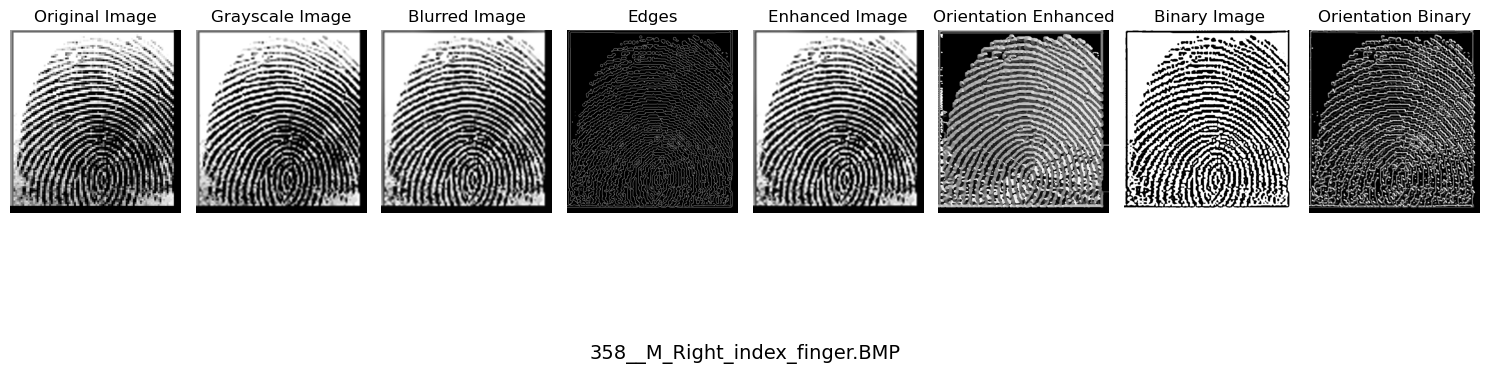

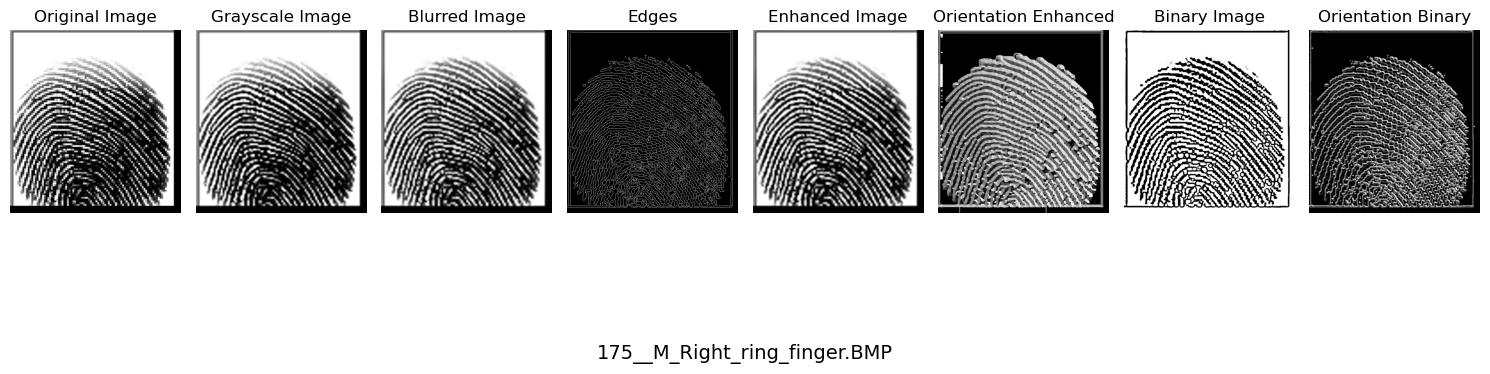

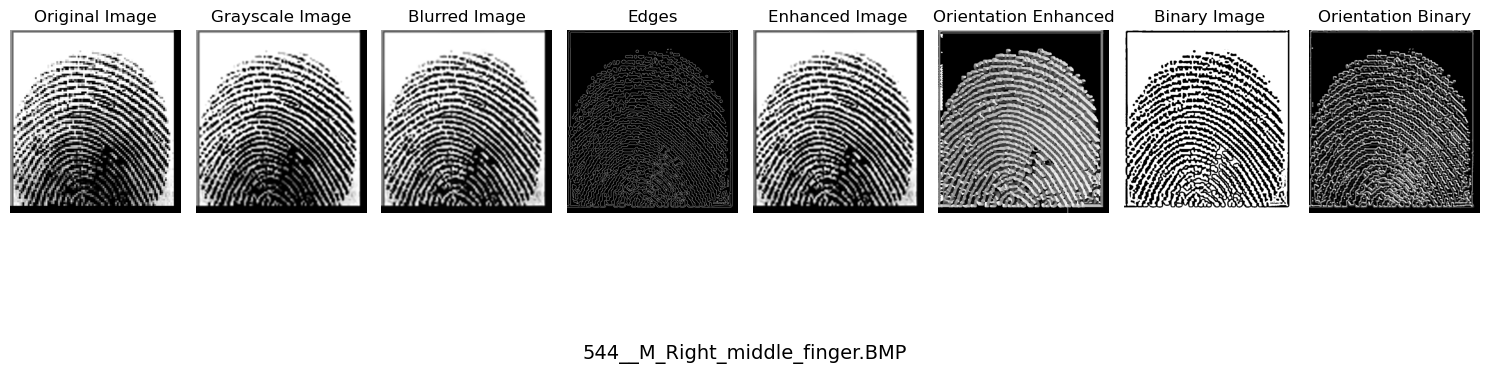

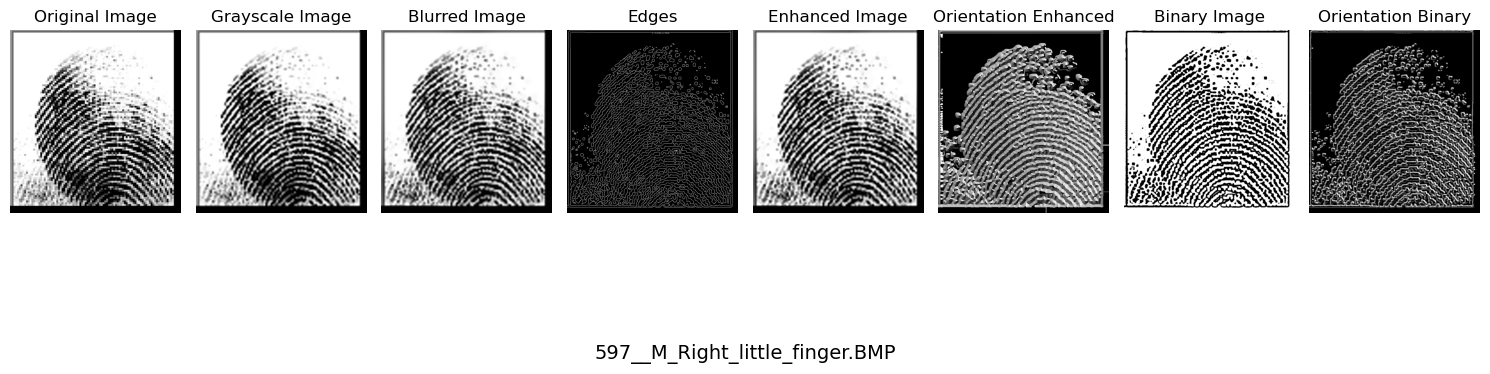

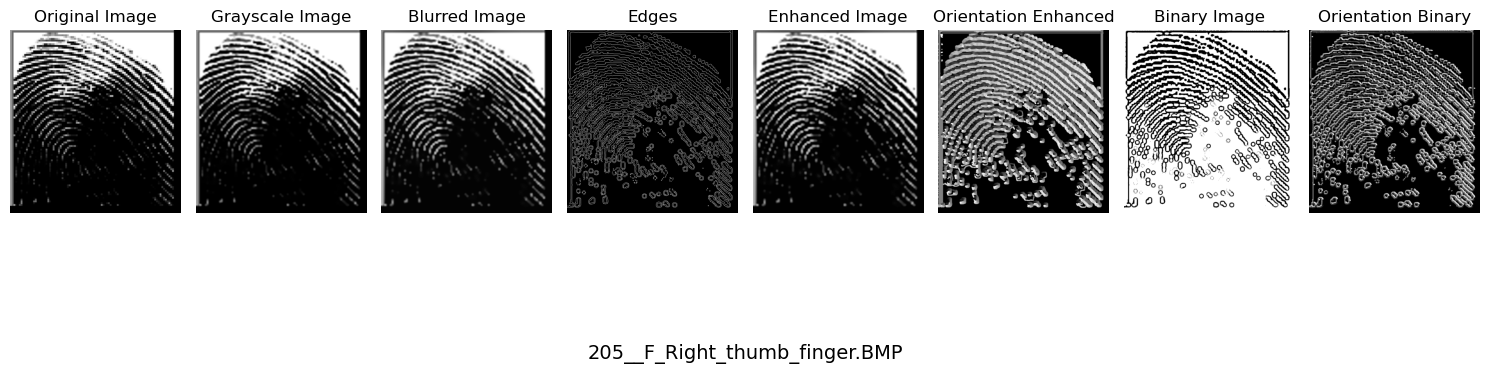

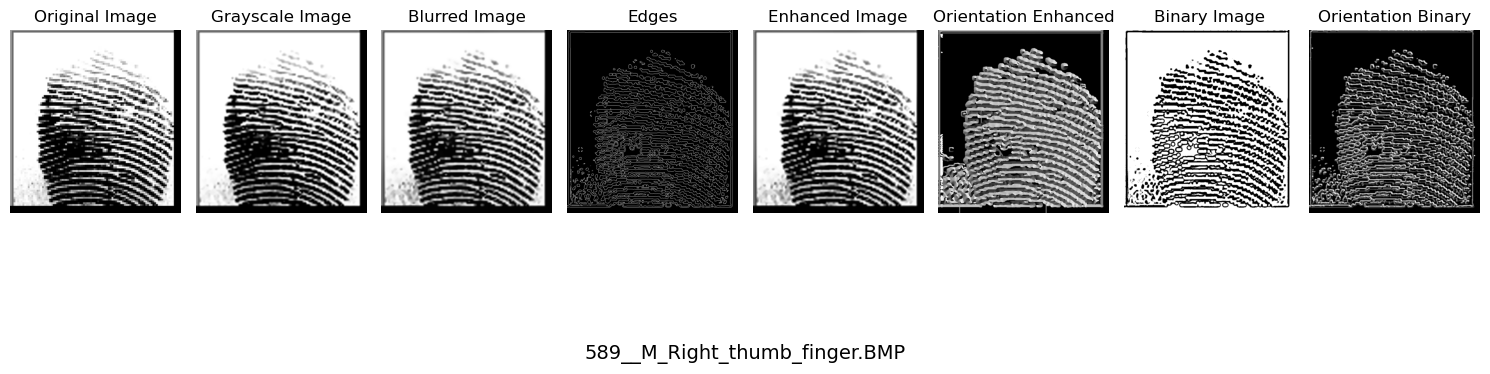

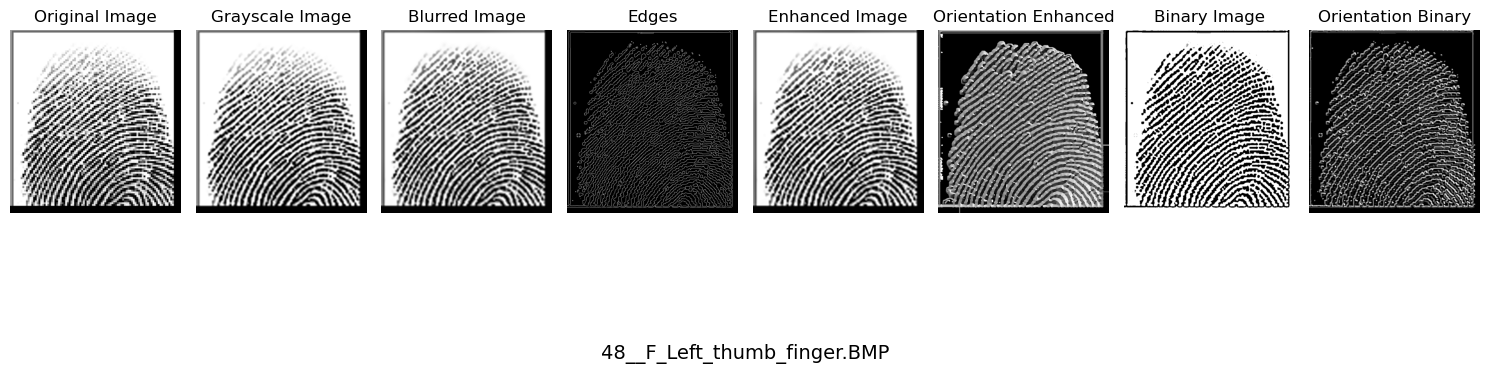

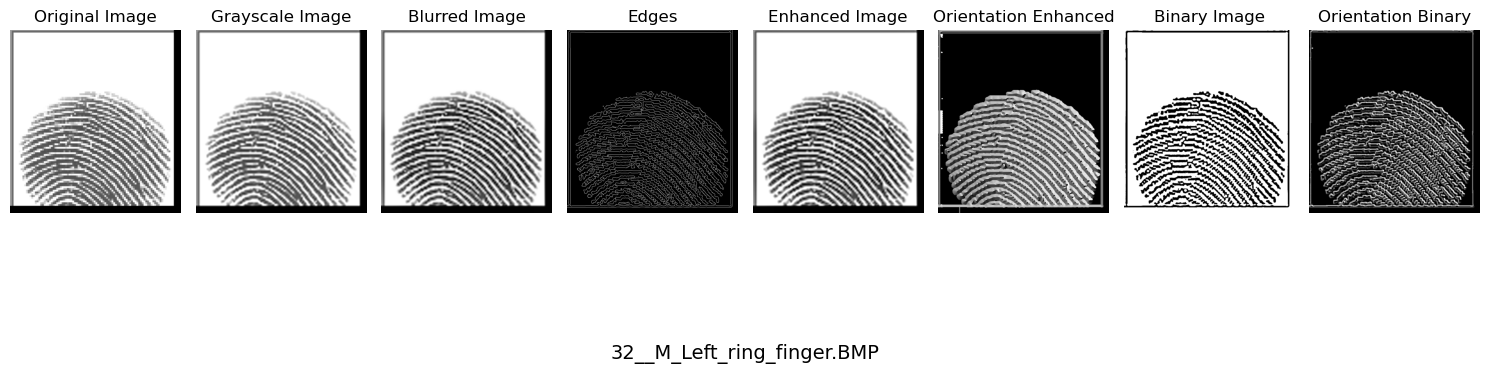

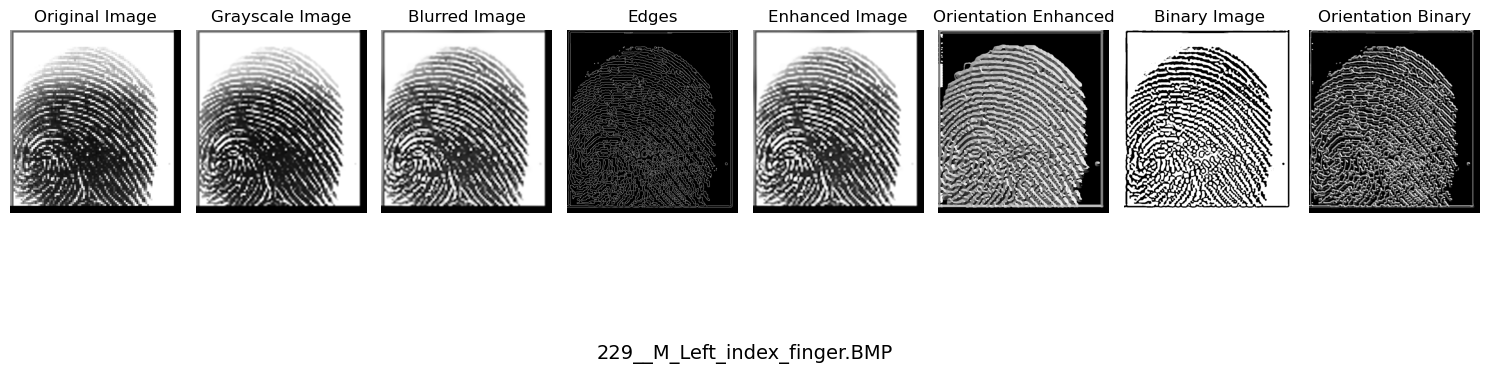

In [4]:
image_dir_altered = r"C:\Users\gamin\.cache\kagglehub\datasets\ruizgara\socofing\versions\2\SOCOFing\Altered"
image_dir_real = r"C:\Users\gamin\.cache\kagglehub\datasets\ruizgara\socofing\versions\2\SOCOFing\Real"

all_images = [f for f in os.listdir(image_dir_real) if f.endswith(('.BMP'))]

selected_images = random.sample(all_images, 10)


def process_and_plot(image_path, image_name):
    # Load the fingerprint image
    image = cv2.imread(image_path)
    
    # Resizing images
    resized_image = cv2.resize(image, (0, 0), fx=7, fy=7, interpolation=cv2.INTER_CUBIC)
    
    # Denoising
    denoised_image = cv2.fastNlMeansDenoising(resized_image, None, 7, 7, 21)
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)
    
    # Working from here
    
    # Blurring
    blurred_image = cv2.GaussianBlur(enhanced_image, (3, 3), 0)
    
    
    #Adaptive threshold    
    binary_image = cv2.adaptiveThreshold(enhanced_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

        
    # Edge
    edges = cv2.Canny(binary_image, threshold1=60, threshold2=120)
    
    # Use gradient-based methods to compute orientation fields
    gradient_x = cv2.Sobel(enhanced_image, cv2.CV_64F, 1, 0, ksize=5)
    gradient_y = cv2.Sobel(enhanced_image, cv2.CV_64F, 0, 1, ksize=5)
    orientation_enhanced = cv2.phase(gradient_x, gradient_y, angleInDegrees=True)
    
    orientation_enhanced_normalized = cv2.normalize(orientation_enhanced, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    output_dir = "Enhanced_processed_images"
    os.makedirs(output_dir, exist_ok=True)
    cv2.imwrite(os.path.join(output_dir, f"{image_name}_enhanced.jpg"), enhanced_image)

    
    gradient_x = cv2.Sobel(binary_image, cv2.CV_64F, 1, 0, ksize=5)
    gradient_y = cv2.Sobel(binary_image, cv2.CV_64F, 0, 1, ksize=5)
    orientation_binary = cv2.phase(gradient_x, gradient_y, angleInDegrees=True)
    
    orientation_binary_normalized = cv2.normalize(orientation_binary, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    output_dir = "Binary_processed_images"
    os.makedirs(output_dir, exist_ok=True)
    cv2.imwrite(os.path.join(output_dir, f"{image_name}_binary.jpg"), binary_image)


    # Plot the results
    fig, axes = plt.subplots(1, 8, figsize=(15, 5))

    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(gray_image, cmap="gray")
    axes[1].set_title("Grayscale Image")
    axes[1].axis("off")
    
    axes[2].imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Blurred Image")
    axes[2].axis("off")

    axes[3].imshow(edges, cmap="gray")
    axes[3].set_title("Edges")
    axes[3].axis("off")
    
    axes[4].imshow(enhanced_image, cmap="gray")
    axes[4].set_title("Enhanced Image")
    axes[4].axis("off")

    axes[5].imshow(orientation_enhanced, cmap="gray")
    axes[5].set_title("Orientation Enhanced")
    axes[5].axis("off")
    
    axes[6].imshow(binary_image, cmap="gray")
    axes[6].set_title("Binary Image")
    axes[6].axis("off")
    
    axes[7].imshow(orientation_binary, cmap="gray")
    axes[7].set_title("Orientation Binary")
    axes[7].axis("off")


    
    fig.suptitle(image_name, fontsize=14, y=0.02)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()
    
    
    

for img_name in selected_images:
    img_path = os.path.join(image_dir_real, img_name)
    process_and_plot(img_path, img_name)
    



In [3]:
def calculate_orientation_field_enhanced(enhanced_image, block_size=16):
    # Tính gradient
    sobel_x = cv2.Sobel(enhanced_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(enhanced_image, cv2.CV_64F, 0, 1, ksize=3)
    
    rows, cols = enhanced_image.shape
    orientation_field = np.zeros((rows // block_size, cols // block_size))

    # Chia thành từng khối
    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):
            block_x = sobel_x[i:i+block_size, j:j+block_size]
            block_y = sobel_y[i:i+block_size, j:j+block_size]
            
            Gx = np.mean(block_x)
            Gy = np.mean(block_y)
            
            theta = 0.5 * np.arctan2(2 * Gx * Gy, Gx**2 - Gy**2)
            orientation_field[i // block_size, j // block_size] = theta

    return orientation_field

'''
# Example Usage
enhanced_image = cv2.imread()

orientation_field = calculate_orientation_field_enhanced(enhanced_image, block_size=16)
plt.title("Orientation Field")
plt.imshow(orientation_field, cmap='hsv')  # HSV for angular data
plt.colorbar()
plt.show()
'''

'\n# Example Usage\nenhanced_image = cv2.imread()\n\norientation_field = calculate_orientation_field_enhanced(enhanced_image, block_size=16)\nplt.title("Orientation Field")\nplt.imshow(orientation_field, cmap=\'hsv\')  # HSV for angular data\nplt.colorbar()\nplt.show()\n'